# Feature Dataset EDA & Baseline Modeling


In [1]:
import json
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from sklearn.model_selection import GroupKFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, average_precision_score, f1_score, classification_report


## Load Dataset

In [11]:
# Adjust path as needed
data_path = Path("../data/features/truthful_qa_script_processed.jsonl")

rows = []
with data_path.open("r", encoding="utf-8") as f:
    for line in f:
        try:
            rows.append(json.loads(line))
        except Exception:
            pass

df = pd.DataFrame(rows)
print(f"Loaded {len(df)} rows across {df['qid'].nunique()} questions.")
print(df.info())
print(df.head())


Loaded 6052 rows across 790 questions.
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6052 entries, 0 to 6051
Data columns (total 46 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   qid                          6052 non-null   int64  
 1   question                     6052 non-null   object 
 2   answer                       6052 non-null   object 
 3   true_answer                  6052 non-null   bool   
 4   best_true_answer             6052 non-null   bool   
 5   best_false_answer            6052 non-null   bool   
 6   group_answer_count           6052 non-null   float64
 7   reading_ease                 6052 non-null   float64
 8   fk_grade                     6052 non-null   float64
 9   sentence_count               6052 non-null   float64
 10  token_count                  6052 non-null   float64
 11  avg_sentence_len             6052 non-null   float64
 12  sentence_len_std             6052 non

## Exploratory Data Analysis

,count,mean,std,min,25%,50%,75%,max
group_answer_count,6052.0,8.634171,3.036169,2.000000,7.000000e+00,8.000000e+00,1.000000e+01,24.000000
reading_ease,6052.0,65.289627,34.273903,-217.180000,4.951842e+01,6.999385e+01,8.670500e+01,121.220000
fk_grade,6052.0,6.228785,4.763280,-3.400000,3.650000e+00,5.863636e+00,8.400000e+00,43.800000
sentence_count,6052.0,1.033708,0.254889,0.000000,1.000000e+00,1.000000e+00,1.000000e+00,4.000000
token_count,6052.0,8.729676,4.685899,0.000000,6.000000e+00,8.000000e+00,1.100000e+01,51.000000
avg_sentence_len,6052.0,8.489783,4.448992,0.000000,5.000000e+00,8.000000e+00,1.100000e+01,37.000000
sentence_len_std,6052.0,0.098665,0.691125,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,11.085526
unique_token_count,6052.0,8.348645,4.203515,0.000000,5.000000e+00,8.000000e+00,1.100000e+01,34.000000
type_token_ratio,6052.0,0.967606,0.083659,0.000000,1.000000e+00,1.000000e+00,1.000000e+00,1.000000
lexical_density,6052.0,0.714361,0.161866,0.000000,6.000000e-01,7.000000e-01,8.000000e-01,1.000000


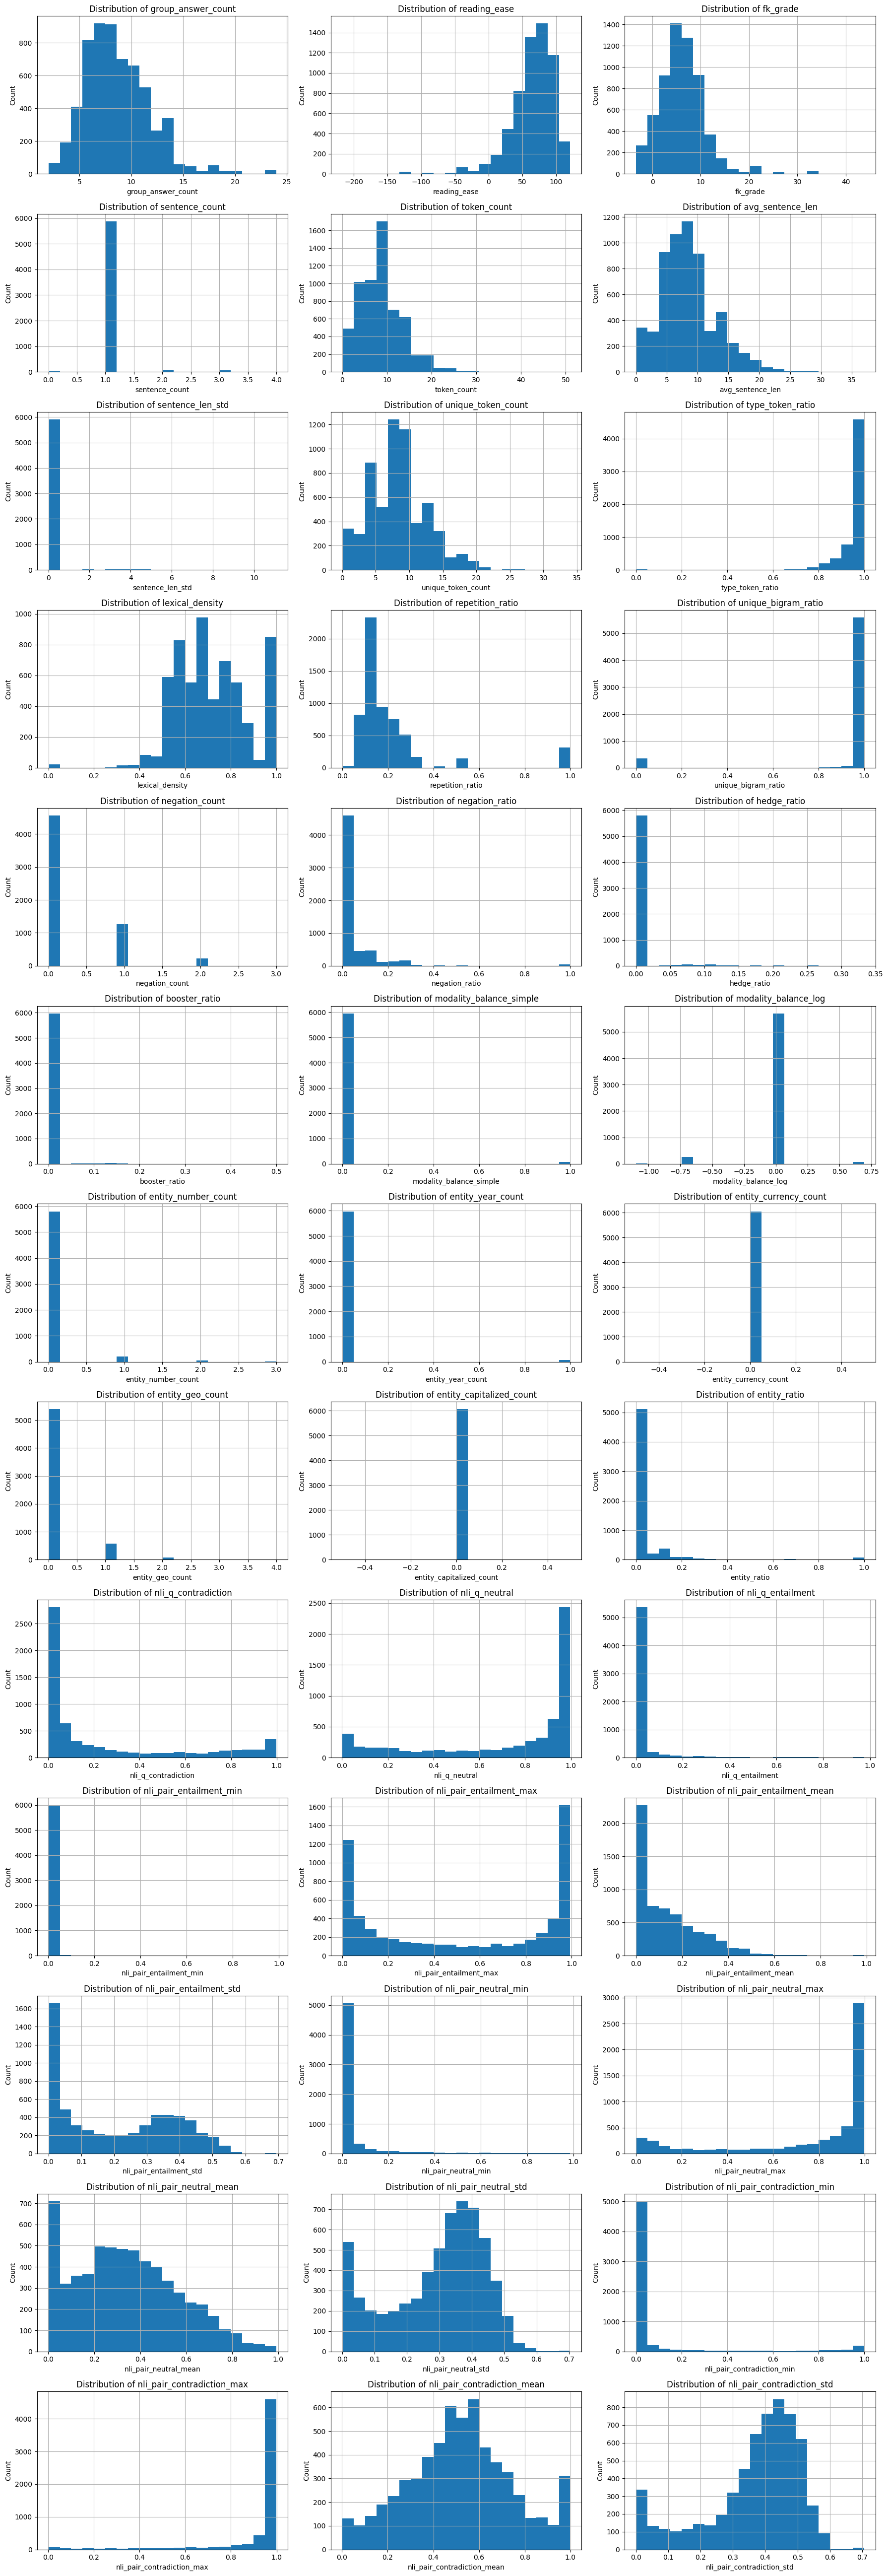

In [14]:
import math
import numpy as np

all_numeric_colnames = [
    "group_answer_count", "reading_ease", "fk_grade", "sentence_count", "token_count",
    "avg_sentence_len", "sentence_len_std", "unique_token_count", "type_token_ratio",
    "lexical_density", "repetition_ratio", "unique_bigram_ratio", "negation_count",
    "negation_ratio", "hedge_ratio", "booster_ratio", "modality_balance_simple",
    "modality_balance_log", "entity_number_count", "entity_year_count",
    "entity_currency_count", "entity_geo_count", "entity_capitalized_count",
    "entity_ratio", "nli_q_contradiction", "nli_q_neutral", "nli_q_entailment",
    "nli_pair_entailment_min", "nli_pair_entailment_max", "nli_pair_entailment_mean",
    "nli_pair_entailment_std", "nli_pair_neutral_min", "nli_pair_neutral_max",
    "nli_pair_neutral_mean", "nli_pair_neutral_std", "nli_pair_contradiction_min",
    "nli_pair_contradiction_max", "nli_pair_contradiction_mean", "nli_pair_contradiction_std"
]
 
display(df[all_numeric_colnames].describe().transpose())

n_cols = 3
n_rows = math.ceil(len(all_numeric_colnames) / n_cols)
fig, axes = plt.subplots(n_rows, n_cols, figsize=(6 * n_cols, 4 * n_rows))
if isinstance(axes, np.ndarray):
    axes = axes.flatten()
else:
    axes = [axes]

for i, col in enumerate(all_numeric_colnames):
    df[col].hist(bins=20, ax=axes[i])
    axes[i].set_title(f"Distribution of {col}")
    axes[i].set_xlabel(col)
    axes[i].set_ylabel("Count")

# Hide any unused subplots
for j in range(i + 1, len(axes)):
    axes[j].set_visible(False)

plt.tight_layout()
plt.show()


## Baseline Modeling (Logistic Regression)

In [18]:
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GroupKFold
from sklearn.metrics import roc_auc_score, average_precision_score, f1_score

# --- Feature matrix / labels / groups as NumPy ---
feature_cols = [c for c in df.columns if c not in [
    "qid","question","answer","true_answer","best_true_answer","best_false_answer"
]]

X = df[feature_cols].fillna(0).to_numpy(dtype=float)             # <— NumPy
y = df["true_answer"].astype(int).to_numpy()                      # <— NumPy
groups = df["qid"].astype(str).to_numpy()                         # <— NumPy (str or int both fine)

pipe = Pipeline([
    ("scaler", StandardScaler(with_mean=True, with_std=True)),
    ("logreg", LogisticRegression(
        max_iter=5000,
        class_weight="balanced",
        solver="lbfgs",    # or "saga" if using elastic-net
        penalty="l2"
    )),
])

gkf = GroupKFold(n_splits=5)

aucs, prs, f1s = [], [], []
for tr, te in gkf.split(X, y, groups=groups):
    pipe.fit(X[tr], y[tr])
    proba = pipe.predict_proba(X[te])[:, 1]
    pred  = (proba >= 0.5).astype(int)
    aucs.append(roc_auc_score(y[te], proba))
    prs.append(average_precision_score(y[te], proba))
    f1s.append(f1_score(y[te], pred))

print("ROC-AUC:", np.mean(aucs))
print("PR-AUC:",  np.mean(prs))
print("F1:",      np.mean(f1s))


ROC-AUC: 0.7755611427505594
PR-AUC: 0.765497188091948
F1: 0.6770843026048972


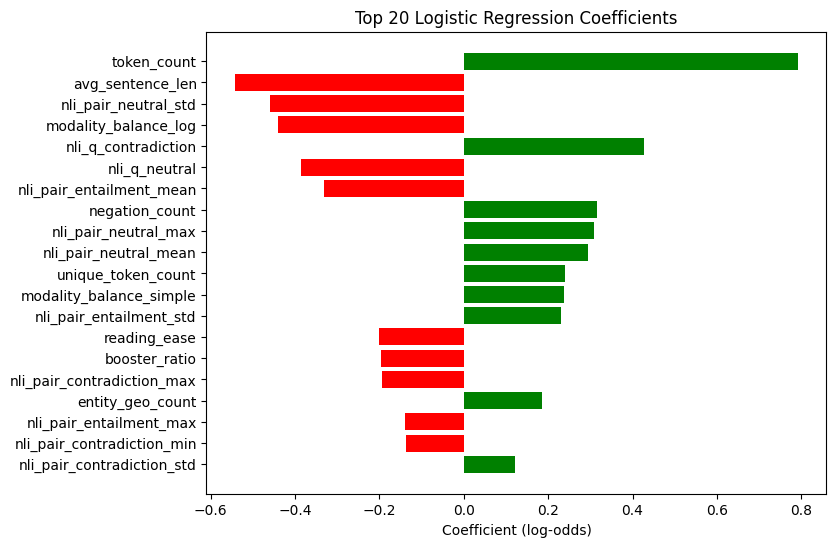

,feature,coefficient
4,token_count,0.792855
5,avg_sentence_len,-0.543158
34,nli_pair_neutral_std,-0.459147
17,modality_balance_log,-0.440359
24,nli_q_contradiction,0.427240
25,nli_q_neutral,-0.385839
29,nli_pair_entailment_mean,-0.330376
12,negation_count,0.315812
32,nli_pair_neutral_max,0.308382
33,nli_pair_neutral_mean,0.293425


In [19]:
import numpy as np
import matplotlib.pyplot as plt

# Refit once on full data to extract coefficients cleanly
pipe.fit(X, y)
coef = pipe.named_steps["logreg"].coef_[0]
feature_names = feature_cols

# Pair feature names with coefficients
coef_df = pd.DataFrame({
    "feature": feature_names,
    "coefficient": coef
})

# Sort by absolute value
coef_df["abs_coef"] = coef_df["coefficient"].abs()
coef_df = coef_df.sort_values("abs_coef", ascending=False).head(20)

# Plot
plt.figure(figsize=(8,6))
colors = ["green" if c > 0 else "red" for c in coef_df["coefficient"]]
plt.barh(coef_df["feature"], coef_df["coefficient"], color=colors)
plt.gca().invert_yaxis()
plt.title("Top 20 Logistic Regression Coefficients")
plt.xlabel("Coefficient (log-odds)")
plt.show()

coef_df.drop(columns="abs_coef")


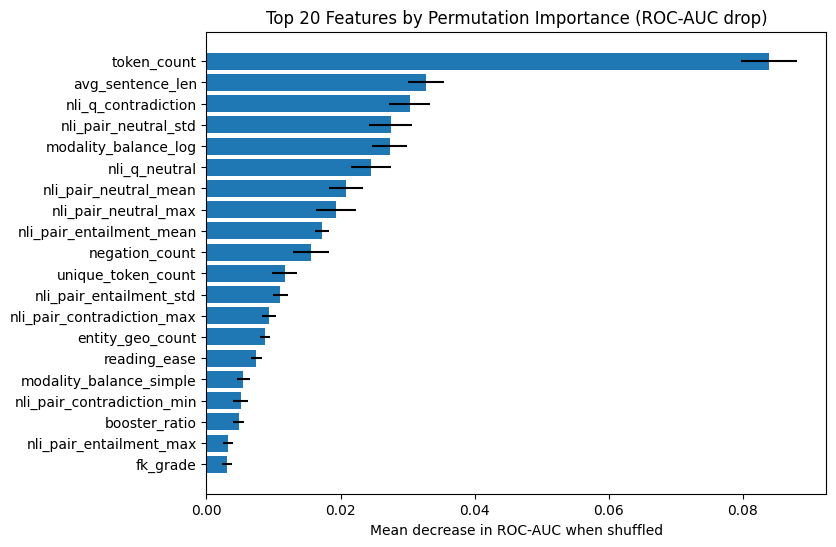

,feature,importance_mean,importance_std
4,token_count,0.083863,0.004202
5,avg_sentence_len,0.032796,0.002698
24,nli_q_contradiction,0.030303,0.003044
34,nli_pair_neutral_std,0.027470,0.003228
17,modality_balance_log,0.027335,0.002636
25,nli_q_neutral,0.024562,0.002971
33,nli_pair_neutral_mean,0.020752,0.002549
32,nli_pair_neutral_max,0.019339,0.002952
29,nli_pair_entailment_mean,0.017272,0.001036
12,negation_count,0.015586,0.002641


In [ ]:
from sklearn.inspection import permutation_importance
from sklearn.utils._bunch import Bunch
from typing import cast

# Refit once on full dataset for permutation importance
pipe.fit(X, y)

result = permutation_importance(pipe, X, y, scoring="roc_auc", n_repeats=10, random_state=42, n_jobs=-1)
result = cast(Bunch, result)  

perm_df = pd.DataFrame({
    "feature": feature_cols,
    "importance_mean": result.importances_mean,
    "importance_std": result.importances_std
}).sort_values("importance_mean", ascending=False).head(20)

# Plot top 20
plt.figure(figsize=(8,6))
plt.barh(perm_df["feature"], perm_df["importance_mean"], xerr=perm_df["importance_std"])
plt.gca().invert_yaxis()
plt.title("Top 20 Features by Permutation Importance (ROC-AUC drop)")
plt.xlabel("Mean decrease in ROC-AUC when shuffled")
plt.show()

perm_df


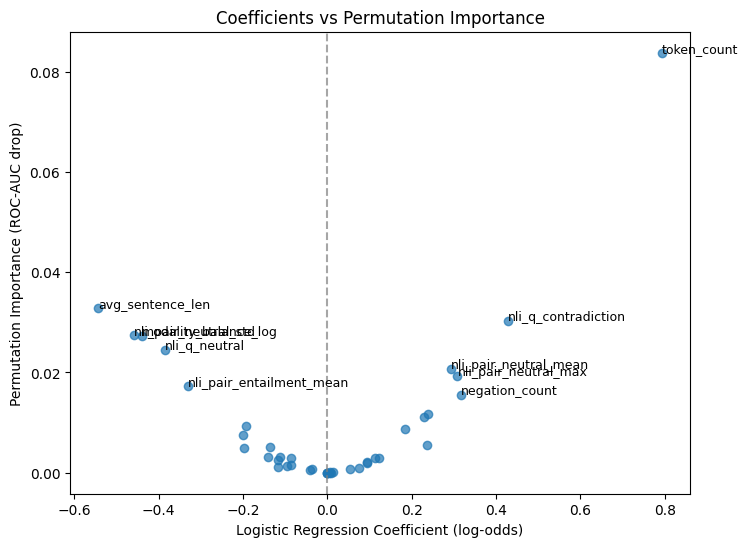

,feature,coefficient,perm_importance
4,token_count,0.792855,0.083863
5,avg_sentence_len,-0.543158,0.032796
24,nli_q_contradiction,0.427240,0.030303
34,nli_pair_neutral_std,-0.459147,0.027470
17,modality_balance_log,-0.440359,0.027335
25,nli_q_neutral,-0.385839,0.024562
33,nli_pair_neutral_mean,0.293425,0.020752
32,nli_pair_neutral_max,0.308382,0.019339
29,nli_pair_entailment_mean,-0.330376,0.017272
12,negation_count,0.315812,0.015586


In [22]:
# Get coefficients again
coef = pipe.named_steps["logreg"].coef_[0]
coef_df = pd.DataFrame({
    "feature": feature_cols,
    "coefficient": coef
})

# Merge with permutation importance
comp_df = coef_df.merge(
    pd.DataFrame({
        "feature": feature_cols,
        "perm_importance": result["importances_mean"] 
    }),
    on="feature"
)

# Plot scatter: Coefficient vs Permutation Importance
plt.figure(figsize=(8,6))
plt.scatter(comp_df["coefficient"], comp_df["perm_importance"], alpha=0.7)

for _, row in comp_df.sort_values("perm_importance", ascending=False).head(10).iterrows():
    plt.text(row["coefficient"], row["perm_importance"], row["feature"], fontsize=9)

plt.axvline(0, color="grey", linestyle="--", alpha=0.7)
plt.title("Coefficients vs Permutation Importance")
plt.xlabel("Logistic Regression Coefficient (log-odds)")
plt.ylabel("Permutation Importance (ROC-AUC drop)")
plt.show()

comp_df.sort_values("perm_importance", ascending=False).head(20)


In [23]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_validate, GroupKFold

# Define Random Forest
rf = RandomForestClassifier(
    n_estimators=300,
    max_depth=None,
    random_state=42,
    n_jobs=-1,
    class_weight="balanced"
)

cv = GroupKFold(n_splits=5)

rf_scores = cross_validate(
    rf, X, y,
    cv=cv,
    groups=df["qid"].to_numpy(),
    scoring=["roc_auc", "average_precision", "f1"],
    return_train_score=False,
    n_jobs=-1
)

print("Random Forest Results:")
print("ROC-AUC:", rf_scores["test_roc_auc"].mean())
print("PR-AUC:", rf_scores["test_average_precision"].mean())
print("F1:", rf_scores["test_f1"].mean())


Random Forest Results:
ROC-AUC: 0.8395922476608797
PR-AUC: 0.8351909201806313
F1: 0.7224387694160679


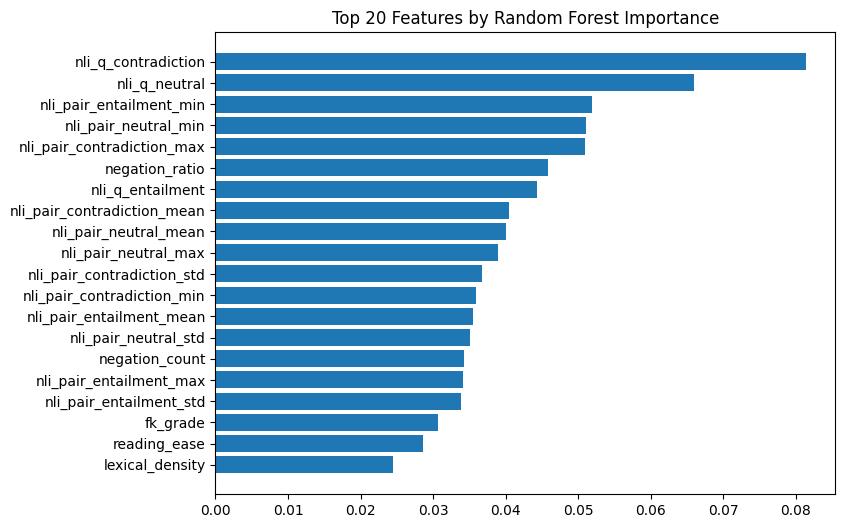

,feature,importance
24,nli_q_contradiction,0.081375
25,nli_q_neutral,0.065988
27,nli_pair_entailment_min,0.051953
31,nli_pair_neutral_min,0.051018
36,nli_pair_contradiction_max,0.050990
13,negation_ratio,0.045799
26,nli_q_entailment,0.044352
37,nli_pair_contradiction_mean,0.040485
33,nli_pair_neutral_mean,0.039976
32,nli_pair_neutral_max,0.038921


In [24]:
importances = rf.fit(X, y).feature_importances_
rf_imp_df = pd.DataFrame({
    "feature": feature_cols,
    "importance": importances
}).sort_values("importance", ascending=False).head(20)

plt.figure(figsize=(8,6))
plt.barh(rf_imp_df["feature"], rf_imp_df["importance"])
plt.gca().invert_yaxis()
plt.title("Top 20 Features by Random Forest Importance")
plt.show()

rf_imp_df


In [25]:
from xgboost import XGBClassifier
from sklearn.model_selection import GroupKFold, cross_validate
import numpy as np

# Define model
xgb = XGBClassifier(
    n_estimators=500,          # more trees
    max_depth=6,               # depth of each tree
    learning_rate=0.05,        # smaller step size
    subsample=0.8,             # random row sampling
    colsample_bytree=0.8,      # random feature sampling
    eval_metric="logloss",     # XGBoost-specific
    use_label_encoder=False,
    n_jobs=-1,
    random_state=42
)

# Grouped CV
cv = GroupKFold(n_splits=5)

scores = cross_validate(
    xgb, X, y,
    cv=cv,
    groups=df["qid"].to_numpy(),   # ensures no leakage across same question
    scoring=["roc_auc", "average_precision", "f1"],
    return_train_score=False,
    n_jobs=-1
)

print("XGBoost ROC-AUC:", scores["test_roc_auc"].mean())
print("XGBoost PR-AUC:", scores["test_average_precision"].mean())
print("XGBoost F1:", scores["test_f1"].mean())


XGBoost ROC-AUC: 0.8363115457216006
XGBoost PR-AUC: 0.8315708506754131
XGBoost F1: 0.7265324062592082
